# COVID data LSTM + CNN

- shape이 안 맞는다...


In [85]:
# module import
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [54]:
# path
root_path = "/content/drive/My Drive/TOY/Data Analysis/Kaggle/novel-COVID"
data_path = f"{root_path}/data"

In [55]:
# load data
df_raw = pd.read_csv(f"{data_path}/covid_19_data.csv")
df = df_raw.copy()

# _1_. 데이터 정제

- 정제 후 `copy`

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53927 entries, 0 to 53926
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SNo              53927 non-null  int64  
 1   ObservationDate  53927 non-null  object 
 2   Province/State   32870 non-null  object 
 3   Country/Region   53927 non-null  object 
 4   Last Update      53927 non-null  object 
 5   Confirmed        53927 non-null  float64
 6   Deaths           53927 non-null  float64
 7   Recovered        53927 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 3.3+ MB


In [57]:
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [58]:
df.tail()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
53922,53923,06/30/2020,Zacatecas,Mexico,2020-07-01 04:33:52,908.0,96.0,626.0
53923,53924,06/30/2020,Zakarpattia Oblast,Ukraine,2020-07-01 04:33:52,2889.0,91.0,943.0
53924,53925,06/30/2020,Zaporizhia Oblast,Ukraine,2020-07-01 04:33:52,572.0,17.0,418.0
53925,53926,06/30/2020,Zhejiang,Mainland China,2020-07-01 04:33:52,1269.0,1.0,1267.0
53926,53927,06/30/2020,Zhytomyr Oblast,Ukraine,2020-07-01 04:33:52,1404.0,29.0,746.0


In [59]:
# 필요 없는 열 제거
df.drop(columns=['SNo'], axis=1, inplace=True)
df.head()

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [60]:
# 그룹핑 통해 일자별 숫자 구하기
df = df.groupby(by=['ObservationDate']).sum()
df.head()

,Confirmed,Deaths,Recovered
ObservationDate,,,
01/22/2020,555.0,17.0,28.0
01/23/2020,653.0,18.0,30.0
01/24/2020,941.0,26.0,36.0
01/25/2020,1438.0,42.0,39.0
01/26/2020,2118.0,56.0,52.0


In [61]:
# 누적합 해체, 일자별 날짜 구하기
df = df - df.shift(1)
df.head()

,Confirmed,Deaths,Recovered
ObservationDate,,,
01/22/2020,NaN,NaN,NaN
01/23/2020,98.0,1.0,2.0
01/24/2020,288.0,8.0,6.0
01/25/2020,497.0,16.0,3.0
01/26/2020,680.0,14.0,13.0


In [62]:
# 결측치 제거
df.dropna(inplace=True)
df.head()

,Confirmed,Deaths,Recovered
ObservationDate,,,
01/23/2020,98.0,1.0,2.0
01/24/2020,288.0,8.0,6.0
01/25/2020,497.0,16.0,3.0
01/26/2020,680.0,14.0,13.0
01/27/2020,809.0,26.0,9.0


,Confirmed,Deaths,Recovered
ObservationDate,,,
01/23/2020,-1.213310,-1.220262,-0.928623
01/24/2020,-1.209784,-1.217588,-0.928512
01/25/2020,-1.205905,-1.214532,-0.928595
01/26/2020,-1.202508,-1.215296,-0.928317
01/27/2020,-1.200114,-1.210711,-0.928428


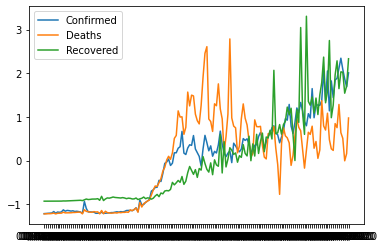

In [63]:
# 표준화
df = (df - df.mean())/df.std()
display(df.head())

plt.plot(df['Confirmed'], label='Confirmed')
plt.plot(df['Deaths'], label='Deaths')
plt.plot(df['Recovered'], label='Recovered')
plt.legend()
plt.show()

In [ ]:
# 복사
data = df.copy()
data.shape

(160, 3)

In [79]:
# train data 생성
def createTrainData(X_data, step):
    m = np.arange(len(X_data)-step)

    # np.array로 바꿔 주기: 안 그러면 나중에 KeyError난다.
    X_data = np.array(X_data)

    X, Y = [], []
    for i in m:
        x = X_data[i:i+step]
        X.append(x)
    for i in m+1:
        y = X_data[i:i+step]
        Y.append(y[-1])

    X = np.reshape(np.array(X), (len(m), step, 3))
    Y = np.reshape(np.array(Y), (len(m), 3))

    return X, Y

# def createTrainData_Conv2d(X_data, step):
#     m = np.arange(len(X_data)-step)
    
#     X_data = np.array(X_data)

#     X, Y = [], []
#     for i in m:
#         x = X_data[i:i+step]
#         X.append(x)
#     for i in m+1:
#         y = X_data[i:i+step]
#         Y.append(y[-1])
    
#     # 4차원 구조로 변환
#     X = np.reshape(np.array(X), (len(m), step, 3, 1)) #

In [81]:
n_step = int(input('학습 스텝 설정: '))
X_data, y_data = createTrainData(data, n_step)
print(f"X: {X_data.shape}, y: {y_data.shape}")

학습 스텝 설정: 10
X: (150, 10, 3), y: (150, 3)


# _2_. 병렬

In [77]:
# params
n_features = X_data.shape[-1]
n_hidden = int(input('FFN 은닉노드 수 설정: '))
n_latent = int(input('LATENT 노드 수 설정: '))
n_output = y_data.shape[-1]

FFN 은닉노드 수 설정: 100
LATENT 노드 수 설정: 64


## _2.1._ LSTM

In [78]:
# LSTM latent feature
lstm_Input = Input(batch_shape = (None, n_step, n_features))
lstm_Lstm = LSTM(n_hidden)(lstm_Input)
lstm_Output = Dense(n_latent)(lstm_Lstm)
print(f"LSTM input: {lstm_Input.shape}")
print(f"LSTM layer: {lstm_Lstm.shape}")
print(f"LSTM output: {lstm_Output.shape}")

LSTM input: (None, 10, 3)
LSTM layer: (None, 100)
LSTM output: (None, 64)


## _2.2._ CNN

In [82]:
# CNN Input data
X_data_conv2d = X_data.reshape(X_data.shape[0], X_data.shape[1], X_data.shape[2], 1)
print(f"X: {X_data_conv2d.shape}, y: {y_data.shape}")

X: (150, 10, 3, 1), y: (150, 3)


In [90]:
# CNNlatent feature
cnn_Input = Input(batch_shape = (None, n_step, n_features, X_data_conv2d.shape[-1]))
cnn_conv2d_1 = Conv2D(filters=30, kernel_size=(8, 1), strides=1, padding='SAME', activation='relu')(cnn_Input)
cnn_pool2d_1 = MaxPooling2D(pool_size=(2, 1), strides=1, padding='VALID')(cnn_conv2d_1)
cnn_conv2d_2 = Conv2D(filters=10, kernel_size=(8, 1), strides=1, padding='SAME', activation='relu')(cnn_pool2d_1)
cnn_pool2d_2 = MaxPooling2D(pool_size=(2, 1), strides=1, padding='VALID')(cnn_conv2d_2)

print(f"CNN input: {cnn_Input.shape}")
print(f"CNN convolution layer 1: {cnn_conv2d_1.shape}")
print(f"CNN pooling layer 1: {cnn_pool2d_1.shape}")
print(f"CNN convolution layer 2: {cnn_conv2d_2.shape}")
print(f"CNN pooling layer 2: {cnn_pool2d_2.shape}")

CNN input: (None, 10, 3, 1)
CNN convolution layer 1: (None, 10, 3, 30)
CNN pooling layer 1: (None, 9, 3, 30)
CNN convolution layer 2: (None, 9, 3, 10)
CNN pooling layer 2: (None, 8, 3, 10)


## 에러 기록

In [68]:
# 모델 구성
x_Input = Input(batch_shape = (None, n_step, n_features))
x_Lstm = LSTM(n_hidden)(x_Input)
x_Output = Dense(n_latent)(x_Lstm)

# 모델 params
LR = float(input('학습률 설정: '))
EPOCHS = int(input('학습 에폭 수 설정: '))
BATCH = int(input('배치 사이즈 설정: '))

lstm_model = Model(x_Input, x_Output)
lstm_model.compile(loss='mse', optimizer=Adam(lr=LR))
print(lstm_model.summary())

# 모델 훈련
lstm_hist = lstm_model.fit(X_data, y_data, epochs=EPOCHS, batch_size=BATCH, shuffle=True)

학습률 설정: 0.01
학습 에폭 수 설정: 300
배치 사이즈 설정: 50
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 10, 3)]           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               41600     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                6464      
Total params: 48,064
Trainable params: 48,064
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300


ValueError: ignored